# Convolutional Neural Networks
---
In this notebook, we train a **CNN** to classify images from the CIFAR-10 database.

The images in this database are small color images that fall into one of ten classes; some example images are pictured below.

<img src='notebook_ims/cifar_data.png' width=70% height=70% />

### Test for [CUDA](http://pytorch.org/docs/stable/cuda.html)

Since these are larger (32x32x3) images, it may prove useful to speed up your training time by using a GPU. CUDA is a parallel computing platform and CUDA Tensors are the same as typical Tensors, only they utilize GPU's for computation.

In [1]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
print(torch.cuda.get_device_name(0))


CUDA is available!  Training on GPU ...
GeForce RTX 2080 Ti


---
## Load the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a minute. We load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader =torch.utils.data.DataLoader(test_data, batch_size=batch_size,num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


### Visualize a Batch of Training Data

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

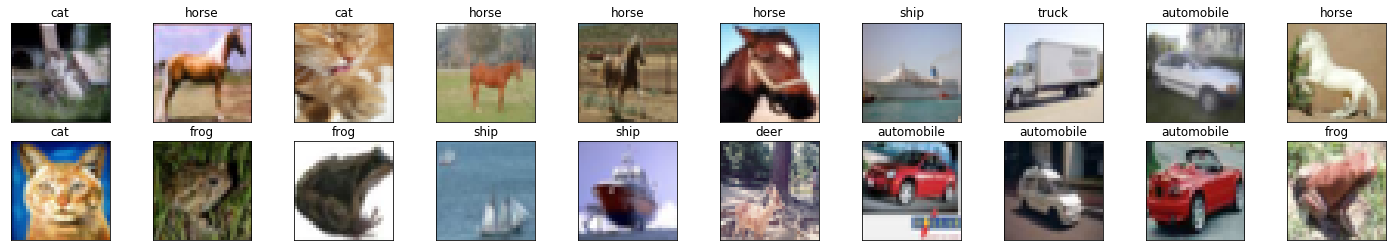

In [4]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### View an Image in More Detail

Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

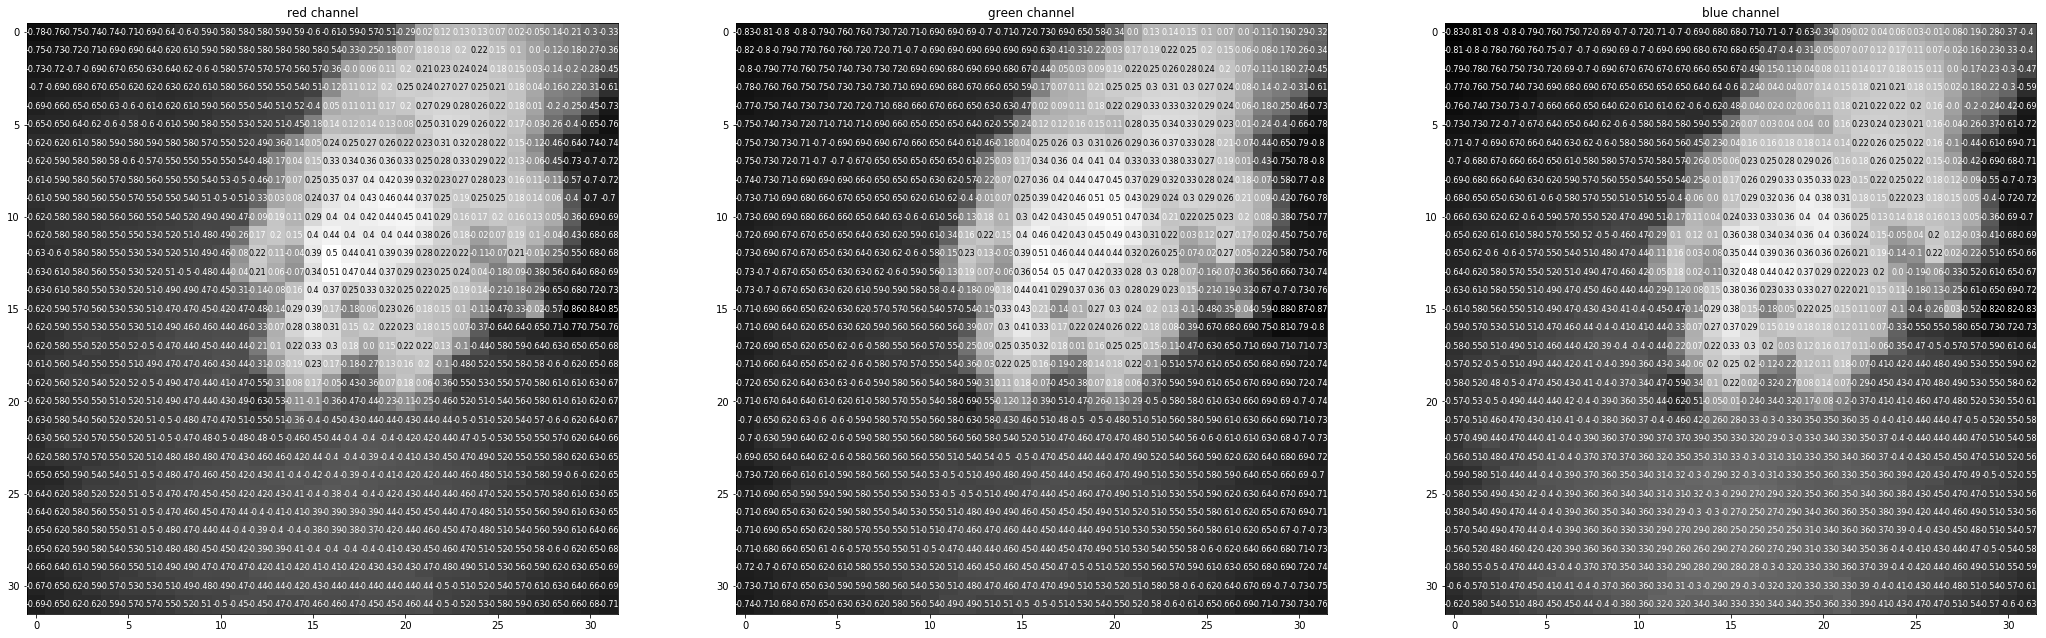

In [5]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

This time, you'll define a CNN architecture. Instead of an MLP, which used linear, fully-connected layers, you'll use the following:
* [Convolutional layers](https://pytorch.org/docs/stable/nn.html#conv2d), which can be thought of as stack of filtered images.
* [Maxpooling layers](https://pytorch.org/docs/stable/nn.html#maxpool2d), which reduce the x-y size of an input, keeping only the most _active_ pixels from the previous layer.
* The usual Linear + Dropout layers to avoid overfitting and produce a 10-dim output.

A network with 2 convolutional layers is shown in the image below and in the code, and you've been given starter code with one convolutional and one maxpooling layer.

<img src='notebook_ims/2_layer_conv.png' height=50% width=50% />

#### TODO: Define a model with multiple convolutional layers, and define the feedforward metwork behavior.

The more convolutional layers you include, the more complex patterns in color and shape a model can detect. It's suggested that your final model include 2 or 3 convolutional layers as well as linear layers + dropout in between to avoid overfitting. 

It's good practice to look at existing research and implementations of related models as a starting point for defining your own models. You may find it useful to look at [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) or [this, more complex Keras example](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py) to help decide on a final structure.

#### Output volume for a convolutional layer

To compute the output size of a given convolutional layer we can perform the following calculation (taken from [Stanford's cs231n course](http://cs231n.github.io/convolutional-networks/#layers)):
> We can compute the spatial size of the output volume as a function of the input volume size (W), the kernel/filter size (F), the stride with which they are applied (S), and the amount of zero padding used (P) on the border. The correct formula for calculating how many neurons define the output_W is given by `(W−F+2P)/S+1`. 

For example for a 7x7 input and a 3x3 filter with stride 1 and pad 0 we would get a 5x5 output. With stride 2 we would get a 3x3 output.

In [5]:

import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(-1,1024)


# define the CNN architecture
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        # convolutional layer
        self.net     = nn.Sequential(OrderedDict([("conv1",nn.Conv2d(3, 16, 3, padding=1)),
                                                  ("relu1",nn.ReLU()),
                                                  ("max_pool1",nn.MaxPool2d(2, 2)),
                                                  ("conv2",nn.Conv2d(16, 32, 3, padding=1)),
                                                  ("relu2",nn.ReLU()),
                                                  ("conv5",nn.Conv2d(32, 32, 3, padding=1)),
                                                  ("relu3",nn.ReLU()),
                                                  ("max_pool2",nn.MaxPool2d(2, 2)),
                                                  ("conv3",nn.Conv2d(32, 64, 3, padding=1)),
                                                  ("relu4",nn.ReLU()),
                                                  ("conv6",nn.Conv2d(64, 64, 3, padding=1)),
                                                  ("relu5",nn.ReLU()),
                                                  ("max_pool3",nn.MaxPool2d(2, 2)),
                                                  ("flat",Flatten()),
                                                  ("fc1", nn.Linear(1024,512)),
                                                  ("relu6",nn.ReLU()),
                                                  ("fc2",nn.Linear(512,10))
                                                 ])) 
        

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x   = self.net(x)
        return x

# create a complete CNN
model = Net1()
print(model)
#for i in model.parameters():
#    print(i)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()


Net1(
  (net): Sequential(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
    (conv5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU()
    (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu4): ReLU()
    (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu5): ReLU()
    (max_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flat): Flatten()
    (fc1): Linear(in_features=1024, out_features=512, bias=True)
    (relu6): ReLU()
    (fc2): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [63]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

Decide on a loss and optimization function that is best suited for this classification task. The linked code examples from above, may be a good starting point; [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) or [this, more complex Keras example](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py). Pay close attention to the value for **learning rate** as this value determines how your model converges to a small error.

#### TODO: Define the loss and optimizer and see how these choices change the loss over time.

In [52]:
import torch.optim as optim

# specify loss function
criterion = nn.CrossEntropyLoss()
# specify optimizer
optimizer = optim.SGD(model.parameters(),lr =0.001)


---
## Train the Network

Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting.

In [18]:
# number of epochs to train the model
n_epochs = 30 # you may increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    #if valid_loss <= valid_loss_min:
    #    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
    #    valid_loss_min,
    #    valid_loss))
    #    torch.save(model.state_dict(), 'model_cifar.pt')
    #    valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.840897 	Validation Loss: 0.459661
Epoch: 2 	Training Loss: 1.836405 	Validation Loss: 0.457714
Epoch: 3 	Training Loss: 1.823493 	Validation Loss: 0.450799
Epoch: 4 	Training Loss: 1.766654 	Validation Loss: 0.423795
Epoch: 5 	Training Loss: 1.678174 	Validation Loss: 0.404790
Epoch: 6 	Training Loss: 1.626182 	Validation Loss: 0.391405
Epoch: 7 	Training Loss: 1.573977 	Validation Loss: 0.377779
Epoch: 8 	Training Loss: 1.526472 	Validation Loss: 0.365426
Epoch: 9 	Training Loss: 1.481033 	Validation Loss: 0.354198
Epoch: 10 	Training Loss: 1.442029 	Validation Loss: 0.344303
Epoch: 11 	Training Loss: 1.400057 	Validation Loss: 0.332490
Epoch: 12 	Training Loss: 1.361180 	Validation Loss: 0.323286
Epoch: 13 	Training Loss: 1.329245 	Validation Loss: 0.315777
Epoch: 14 	Training Loss: 1.302525 	Validation Loss: 0.309127
Epoch: 15 	Training Loss: 1.277025 	Validation Loss: 0.303228
Epoch: 16 	Training Loss: 1.257573 	Validation Loss: 0.299929
Epoch: 17 	Traini

###  Train my Model

In [8]:
model_scat = Net1()
if(torch.cuda.is_available()):
  model_scat = model_scat.cuda()

import torch.optim as optim

# specify loss function
criterion = nn.CrossEntropyLoss()
# specify optimizer
optimizer = optim.SGD(model_scat.parameters(),lr =0.001)
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))


# number of epochs to train the model
n_epochs = 100 # you may increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model_scat.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_scat(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model_scat.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_scat(data)
        _, pred = torch.max(output, 1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        for i in range(batch_size):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1
        # calculate the batch loss
        
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    if(epoch %5==0):
      for i in range(10):
       if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
       else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))   
       # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} '.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model_scat.state_dict(), 'model_cifar_my_model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.842016 	Validation Loss: 0.460472 
Validation loss decreased (inf --> 0.460472).  Saving model ...
Epoch: 2 	Training Loss: 1.841753 	Validation Loss: 0.460409 
Validation loss decreased (0.460472 --> 0.460409).  Saving model ...
Epoch: 3 	Training Loss: 1.841492 	Validation Loss: 0.460339 
Validation loss decreased (0.460409 --> 0.460339).  Saving model ...
Epoch: 4 	Training Loss: 1.841160 	Validation Loss: 0.460241 
Validation loss decreased (0.460339 --> 0.460241).  Saving model ...
Test Accuracy of airplane:  1% (53/4895)
Test Accuracy of automobile:  0% ( 0/5105)
Test Accuracy of  bird:  0% ( 2/4885)
Test Accuracy of   cat:  0% ( 0/5105)
Test Accuracy of  deer:  0% ( 0/5010)
Test Accuracy of   dog:  0% ( 0/5025)
Test Accuracy of  frog:  0% ( 0/4950)
Test Accuracy of horse: 38% (1909/4955)
Test Accuracy of  ship: 90% (4569/5030)
Test Accuracy of truck:  0% ( 0/5040)
Epoch: 5 	Training Loss: 1.840635 	Validation Loss: 0.460069 
Validation loss decreased (

Epoch: 41 	Training Loss: 0.950488 	Validation Loss: 0.254457 
Validation loss decreased (0.255045 --> 0.254457).  Saving model ...
Epoch: 42 	Training Loss: 0.936489 	Validation Loss: 0.251744 
Validation loss decreased (0.254457 --> 0.251744).  Saving model ...
Epoch: 43 	Training Loss: 0.921539 	Validation Loss: 0.244520 
Validation loss decreased (0.251744 --> 0.244520).  Saving model ...
Epoch: 44 	Training Loss: 0.906408 	Validation Loss: 0.241947 
Validation loss decreased (0.244520 --> 0.241947).  Saving model ...
Test Accuracy of airplane: 49% (21803/44055)
Test Accuracy of automobile: 42% (19492/45945)
Test Accuracy of  bird: 19% (8538/43965)
Test Accuracy of   cat: 19% (9121/45945)
Test Accuracy of  deer: 26% (11731/45090)
Test Accuracy of   dog: 35% (16136/45225)
Test Accuracy of  frog: 47% (21180/44550)
Test Accuracy of horse: 45% (20238/44595)
Test Accuracy of  ship: 57% (26085/45270)
Test Accuracy of truck: 45% (20824/45360)
Epoch: 45 	Training Loss: 0.892870 	Validation

Epoch: 91 	Training Loss: 0.172924 	Validation Loss: 0.345584 
Epoch: 92 	Training Loss: 0.161704 	Validation Loss: 0.359891 
Epoch: 93 	Training Loss: 0.147835 	Validation Loss: 0.372794 
Epoch: 94 	Training Loss: 0.135986 	Validation Loss: 0.389594 
Test Accuracy of airplane: 59% (55280/93005)
Test Accuracy of automobile: 58% (56952/96995)
Test Accuracy of  bird: 35% (32727/92815)
Test Accuracy of   cat: 31% (30579/96995)
Test Accuracy of  deer: 41% (39826/95190)
Test Accuracy of   dog: 43% (41383/95475)
Test Accuracy of  frog: 56% (53520/94050)
Test Accuracy of horse: 57% (54399/94145)
Test Accuracy of  ship: 67% (64932/95570)
Test Accuracy of truck: 57% (55378/95760)
Epoch: 95 	Training Loss: 0.125721 	Validation Loss: 0.394254 
Epoch: 96 	Training Loss: 0.122028 	Validation Loss: 0.411056 
Epoch: 97 	Training Loss: 0.102396 	Validation Loss: 0.421596 
Epoch: 98 	Training Loss: 0.097210 	Validation Loss: 0.413138 
Epoch: 99 	Training Loss: 0.084573 	Validation Loss: 0.431291 
Test 

# Changing the output for visualization

In [16]:
model_scat2 = Net1()
model_scat2.load_state_dict(torch.load('model_cifar_my_model.pt'))
print(model_scat2)

Net1(
  (net): Sequential(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
    (conv5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU()
    (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu4): ReLU()
    (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu5): ReLU()
    (max_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flat): Flatten()
    (fc1): Linear(in_features=1024, out_features=512, bias=True)
    (relu6): ReLU()
    (fc2): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [12]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
#print(images[0].numpy().shape)
#op1,op2,op3,op4 = model_visual(images[0])
#print(op4.shape)
from PIL import Image


for name, param in model.named_parameters():
    print(name, param.size())


    
dic ={} 
x = images[0].unsqueeze(0)
print(x.shape)    
for i,j in model_scat2.net._modules.items():
    print(i)
    x = j(x)
    dic[i] =x
    print(i,x.shape)

net.conv1.weight torch.Size([16, 3, 3, 3])
net.conv1.bias torch.Size([16])
net.conv2.weight torch.Size([32, 16, 3, 3])
net.conv2.bias torch.Size([32])
net.conv5.weight torch.Size([32, 32, 3, 3])
net.conv5.bias torch.Size([32])
net.conv3.weight torch.Size([64, 32, 3, 3])
net.conv3.bias torch.Size([64])
net.conv6.weight torch.Size([64, 64, 3, 3])
net.conv6.bias torch.Size([64])
net.fc1.weight torch.Size([512, 1024])
net.fc1.bias torch.Size([512])
net.fc2.weight torch.Size([10, 512])
net.fc2.bias torch.Size([10])
torch.Size([1, 3, 32, 32])
conv1
conv1 torch.Size([1, 16, 32, 32])
relu1
relu1 torch.Size([1, 16, 32, 32])
max_pool1
max_pool1 torch.Size([1, 16, 16, 16])
conv2
conv2 torch.Size([1, 32, 16, 16])
relu2
relu2 torch.Size([1, 32, 16, 16])
conv5
conv5 torch.Size([1, 32, 16, 16])
relu3
relu3 torch.Size([1, 32, 16, 16])
max_pool2
max_pool2 torch.Size([1, 32, 8, 8])
conv3
conv3 torch.Size([1, 64, 8, 8])
relu4
relu4 torch.Size([1, 64, 8, 8])
conv6
conv6 torch.Size([1, 64, 8, 8])
relu5
rel

(1, 8, 8, 64)


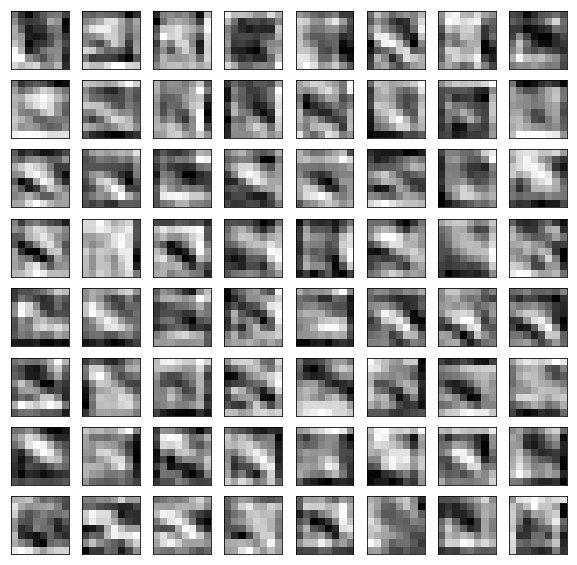

In [37]:
feature_maps = dic["conv6"].detach().numpy()
feature_maps = feature_maps.transpose(0,2,3,1)
print(feature_maps.shape)
square = 8
ix = 1
plt.figure(figsize=(10,10))
for _ in range(square):
  for _ in range(square):
     # specify subplot and turn of axis
     ax = plt.subplot(square, square, ix)
     ax.set_xticks([])
     ax.set_yticks([])
     # plot filter channel in grayscale
     plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
     ix += 1
# show the figure
plt.show()

---
## Test the Trained Network

Test your trained model on previously unseen data! A "good" result will be a CNN that gets around 70% (or more, try your best!) accuracy on these test images.

In [21]:


if torch.cuda.is_available():
    model_scat2 = model_scat2.cuda()

# specify loss function
criterion = nn.CrossEntropyLoss()
# specify optimizer
optimizer = optim.SGD(model_scat2.parameters(),lr =0.001)
# track test loss
batch_size =16
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model_scat2.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    print("DATA_TARGET",data.shape,target.shape)
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model_scat2(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    #print(output[0,:])
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

DATA_TARGET torch.Size([64, 3, 32, 32]) torch.Size([64])
DATA_TARGET torch.Size([64, 3, 32, 32]) torch.Size([64])
DATA_TARGET torch.Size([64, 3, 32, 32]) torch.Size([64])
DATA_TARGET torch.Size([64, 3, 32, 32]) torch.Size([64])
DATA_TARGET torch.Size([64, 3, 32, 32]) torch.Size([64])
DATA_TARGET torch.Size([64, 3, 32, 32]) torch.Size([64])
DATA_TARGET torch.Size([64, 3, 32, 32]) torch.Size([64])
DATA_TARGET torch.Size([64, 3, 32, 32]) torch.Size([64])
DATA_TARGET torch.Size([64, 3, 32, 32]) torch.Size([64])
DATA_TARGET torch.Size([64, 3, 32, 32]) torch.Size([64])
DATA_TARGET torch.Size([64, 3, 32, 32]) torch.Size([64])
DATA_TARGET torch.Size([64, 3, 32, 32]) torch.Size([64])
DATA_TARGET torch.Size([64, 3, 32, 32]) torch.Size([64])
DATA_TARGET torch.Size([64, 3, 32, 32]) torch.Size([64])
DATA_TARGET torch.Size([64, 3, 32, 32]) torch.Size([64])
DATA_TARGET torch.Size([64, 3, 32, 32]) torch.Size([64])
DATA_TARGET torch.Size([64, 3, 32, 32]) torch.Size([64])
DATA_TARGET torch.Size([64, 3, 

DATA_TARGET torch.Size([64, 3, 32, 32]) torch.Size([64])
DATA_TARGET torch.Size([64, 3, 32, 32]) torch.Size([64])
DATA_TARGET torch.Size([64, 3, 32, 32]) torch.Size([64])
DATA_TARGET torch.Size([64, 3, 32, 32]) torch.Size([64])
DATA_TARGET torch.Size([64, 3, 32, 32]) torch.Size([64])
DATA_TARGET torch.Size([64, 3, 32, 32]) torch.Size([64])
DATA_TARGET torch.Size([64, 3, 32, 32]) torch.Size([64])
DATA_TARGET torch.Size([64, 3, 32, 32]) torch.Size([64])
DATA_TARGET torch.Size([64, 3, 32, 32]) torch.Size([64])
DATA_TARGET torch.Size([64, 3, 32, 32]) torch.Size([64])
DATA_TARGET torch.Size([64, 3, 32, 32]) torch.Size([64])
DATA_TARGET torch.Size([64, 3, 32, 32]) torch.Size([64])
DATA_TARGET torch.Size([16, 3, 32, 32]) torch.Size([16])
Test Loss: 0.960424

Test Accuracy of airplane: 77% (181/234)
Test Accuracy of automobile: 84% (209/246)
Test Accuracy of  bird: 64% (180/281)
Test Accuracy of   cat: 47% (119/253)
Test Accuracy of  deer: 49% (113/227)
Test Accuracy of   dog: 49% (123/250)
Te

### Question: What are your model's weaknesses and how might they be improved?

**Answer**: (double-click to edit and add an answer)

### Visualize Sample Test Results

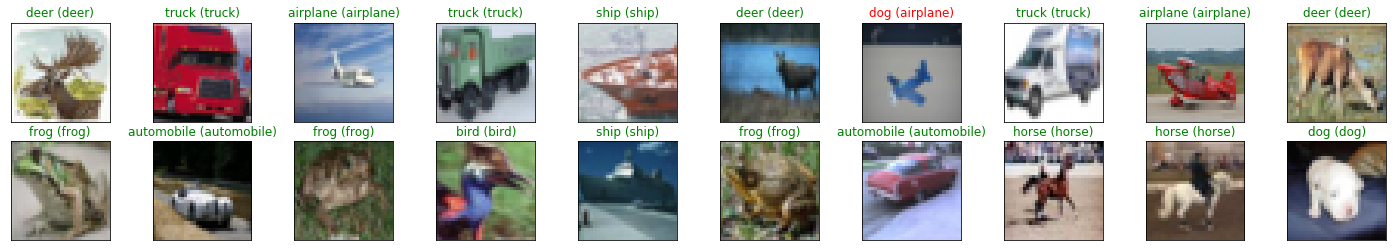

In [11]:
# obtain one batch of test images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model_scat2(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
images =images.cpu()
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))